# Continuous Control



### STEP 1. Start the Environment, you can download the required file by getting it from the README.md to refer to how to get unity environment setup



In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### Retrieve the environment settings from Unity environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### Add in DDPG algorithm for the agent to learn.

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_layers=[256,128]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_layers (list): Number of nodes in hidden layers
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        dims = [state_size] + fc_layers + [action_size]
        self.fc_layers = nn.ModuleList(
            [nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.reset_parameters()

        print('Actor network built:', self.fc_layers)



    def reset_parameters(self):
        for layer in self.fc_layers[:-1]:
            layer.weight.data.uniform_(*hidden_init(layer) )
        self.fc_layers[-1].weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, x):
        """Build an actor (policy) network that maps states -> actions.
        Params
        ======
            x (state shape): state passed to the network
        """
        for layer in self.fc_layers[:-1]:
            x = F.relu(layer(x))
        return F.tanh(self.fc_layers[-1](x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc_layers=[256,128]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_layers (list): Number of nodes in hidden layers
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        dims = fc_layers + [1]
        layers_list = []

        layers_list.append(nn.Linear(state_size, dims[0]))
        layers_list.append(nn.Linear(dims[0] + action_size, dims[1]))

        for dim_in, dim_out in zip(dims[1:-1], dims[2:]):
            layers_list.append(nn.Linear(dim_in, dim_out))

        self.fc_layers = nn.ModuleList(layers_list)
        self.reset_parameters()
        # Add batch normalization to the first hidden layer
        self.bn = nn.BatchNorm1d(dims[0])
        print('Critic network built:', self.fc_layers)

    def reset_parameters(self):
        for layer in self.fc_layers[:-1]:
            layer.weight.data.uniform_(*hidden_init(layer) )
        self.fc_layers[-1].weight.data.uniform_(-3e-3, 3e-3)


    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

        x_state = F.relu(self.bn(self.fc_layers[0](state)))
        # Concatenate the first layer output with the action
        x = torch.cat((x_state, action), dim=1)
        for layer in self.fc_layers[1:-1]:
            x = F.relu(layer(x))
        # Pass the result through the output layer  sigmoid activation
        x = torch.sigmoid(self.fc_layers[-1](x))
        return x

### Setting up the agent , replay buffer and noise to add for agent learning

In [6]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

# from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay
NOISE_DECAY = 0.999     # noise decay
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        print('DDPG Agent hyperparameters:\n\t' \
              'batch size: \t\t{:8.0f}\n\t' \
              'buffer size: \t\t{:8.0f}\n\t' \
              'discount / gamma: \t{:8.3f}\n\t' \
              'actor learning rate: \t{:8.3f}\n\t' \
              'critic learning rate: \t{:8.3f}\n\t' \
              'soft update / tau: \t{:8.3f}\n\t' \
              'noise decay rate: \t{:8.3f}\n\t' #\
              .format(BUFFER_SIZE, BUFFER_SIZE, GAMMA,
                      LR_ACTOR, LR_CRITIC, TAU, NOISE_DECAY))#, WEIGHT_DECAY))

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)#, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.noise_decay = NOISE_DECAY

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() * self.noise_decay
            self.noise_decay *= self.noise_decay
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


### DDPG agent Configuration and Hyperparameters

In [7]:
agents=[]
for agent in range(0,num_agents): 
   agents.append(Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size, random_seed=10))

DDPG Agent hyperparameters:
	batch size: 		 1000000
	buffer size: 		 1000000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.001
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999
	
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=4, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=4, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=256, bias=True)
  (1): Linear(in_features=260, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=256, bias=True)
  (1): Linear(in_features=260, out_fea

In [8]:
def ddpg(n_episodes=2000, max_t=1000):
    episode_scores_deque = deque(maxlen=100)
    episode_scores = []     
    max_score = -np.Inf
        
    for i_episode in range(1, n_episodes+1):
        env_info = env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)   
        for agent in agents:  agent.reset() #agent.reset() #for agent in agents:  agent.reset()
        
        for t in range(max_t):
            actions=[]
            for i in range(num_agents): 
                actions.append(agents[i].act(states[i]))  # select an action (for each agent)
            env_info = env.step(actions)[brain_name]                    # send all actions to tne environment
            next_states = env_info.vector_observations                  # get next state (for each agent)
            rewards = env_info.rewards                                  # get reward (for each agent)
            dones = env_info.local_done                                 # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)    # update weights (for each agent)
            scores += env_info.rewards                                  # update the score (for each agent)
            states = next_states                                        # roll over states to next time step
            
            if np.any(dones):                                           # exit loop if episode finished
                break
        episode_scores_deque.append(np.mean(scores))            # append the avg score by agents in this eposide
        episode_scores.append(np.mean(scores))                  # append the avg score by agents in this eposide
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(episode_scores_deque), np.mean(scores)), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_batchnormalization.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_batchnormalization.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(episode_scores_deque)))
        if np.mean(episode_scores_deque) >= 30.0 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(episode_scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_batchnormalization.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_batchnormalization.pth')
            break
    return episode_scores

scores = ddpg() 



Episode 100	Average Score: 6.73	Score: 17.68
Episode 200	Average Score: 29.31	Score: 38.13
Episode 203	Average Score: 30.10	Score: 35.73
Environment solved in 203 episodes!	Average Score: 30.10


### Visualizing reward graph on a single agent

Text(0.5,1,'Reward graph for single agent')

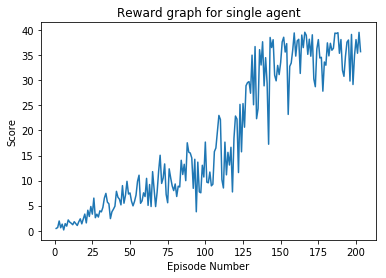

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode Number')
plt.title('Reward graph for single agent')


In [ ]:
env.close()